# Using Long Simulations instead of Accelerated Simulations

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh_V/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_sens/"
res_DIR = "../data/results_sens/"

In [2]:
parameter_values = get_parameter_values()

In [3]:
cell = 22
# cell = 23

In [4]:
cell_no,dfe,N = load_data_calendar(cell,eSOH_DIR)

Cycle Numbers:
0.0, 25.2705671642907, 93.0685096180532, 130.029355057864, 168.119850242976, 204.058473101817, 245.030302534695


In [5]:
# C_n_init,C_p_init,x_init,y_init,c_rate_c,c_rate_d,dis_set = init_exp(cell_no,dfe)
C_n_init,C_p_init,SOC_0 = init_exp_calendar(cell_no,dfe)

In [6]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
calendar_time = 24
experiment = pybamm.Experiment(
    [
        ("Rest for "+f'{calendar_time}'+" hours",)
    ]*250 ,
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [7]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.n.L * param.n.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.p.L * param.p.c_max * param.F* param.A_cc))
# cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [8]:
Temp = [25,45,-5]
k_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,10]
# d_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,100]
d_sei = [1,1e-1,1e1,1e-2,1e2,1e-3,1e3,1e-4,1e4]


In [9]:
ksei_idx = 0
dsei_idx = 0
Temp_idx = 0

In [10]:
parameter_values = get_parameter_values()

parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
        "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
        "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
        # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
        "Initial temperature [K]": 273.15+Temp[Temp_idx],
        "Ambient temperature [K]": 273.15+Temp[Temp_idx],
    },
    check_already_exists=False,
)

In [11]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=1)
long_sol_output =sol_long.summary_variables
df = pd.DataFrame.from_dict(long_sol_output)
df.to_csv(res_DIR+'sens_long_T_{0}_k_{1}_D_{2}'.format(str(Temp_idx),str(ksei_idx),str(dsei_idx))+'.csv')

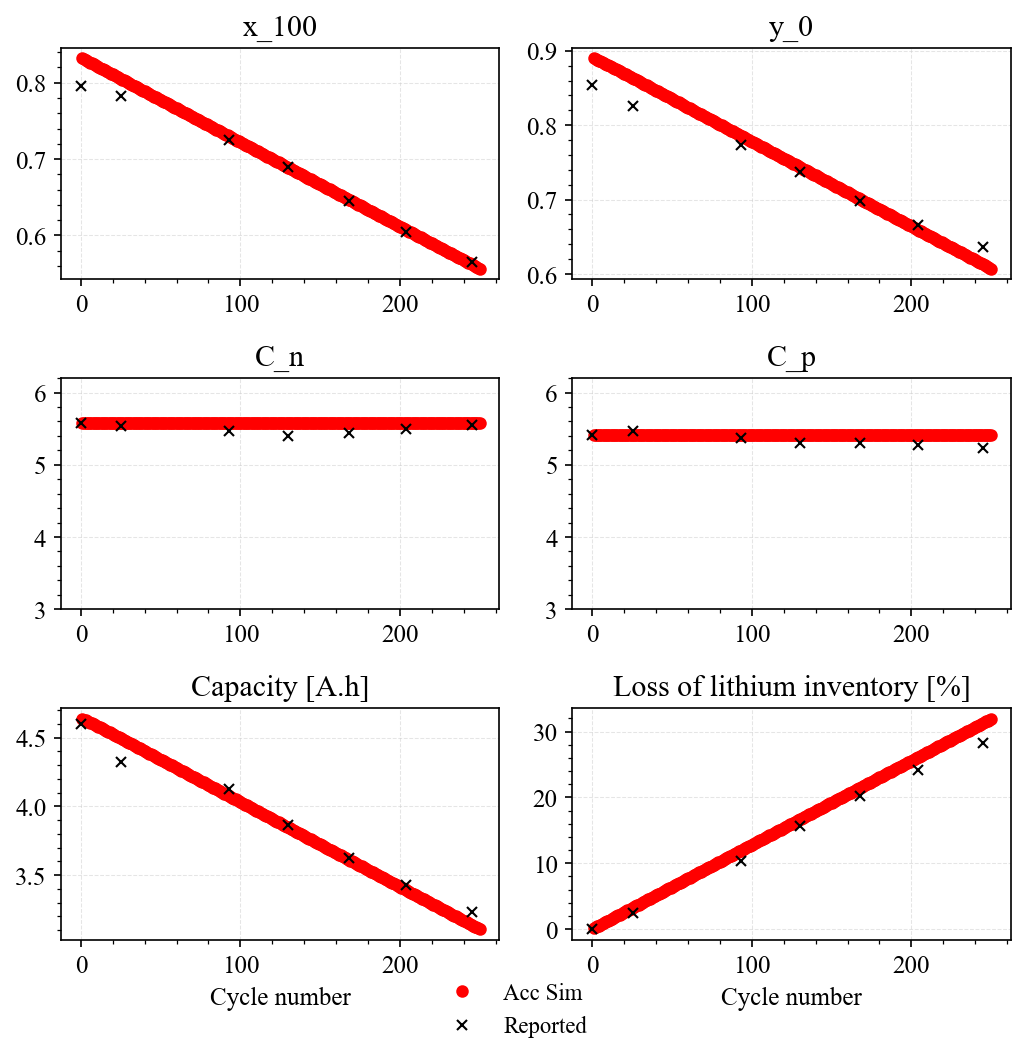

In [12]:
fig = plotc(long_sol_output,dfe);
# plt.savefig(fig_DIR +'calendar_aging_cell_'+cell_no+'_eSOH.png')

In [13]:
len(k_sei)

9

In [14]:
def sens_sim(ksei_idx=0,dsei_idx=0,Temp_idx=0):
    parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
            # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
            # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
            "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
            "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
            "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
            "Positive electrode LAM constant exponential term": 2,
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
            # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
            "Initial temperature [K]": 273.15+Temp[Temp_idx],
            "Ambient temperature [K]": 273.15+Temp[Temp_idx],
        },
        check_already_exists=False,
    )
    sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
    sol_long = sim_long.solve(initial_soc=1)
    long_sol_output_1 =sol_long.summary_variables
    df_1 = pd.DataFrame.from_dict(long_sol_output_1)
    fig = plotcomp(long_sol_output,long_sol_output_1);
    plt.savefig(fig_DIR+'sens_long_T_{0}_k_{1}_D_{2}'.format(str(Temp_idx),str(ksei_idx),str(dsei_idx))+'_eSOH.png');
    df_1 = pd.DataFrame.from_dict(long_sol_output_1)
    df_1.to_csv(res_DIR+'sens_long_T_{0}_k_{1}_D_{2}'.format(str(Temp_idx),str(ksei_idx),str(dsei_idx))+'.csv')
    ## Long Sims
    # sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
    #                         solver=pybamm.CasadiSolver("safe"))
    # sol_long = sim_long.solve(initial_soc=1)
    # long_sol_output =sol_long.summary_variables
    # df_l = pd.DataFrame.from_dict(long_sol_output)
    # df_1.to_csv(res_DIR+'sens_long_T_{0}_k_{1}_D_{2}'.format(str(Temp_idx),str(ksei_idx),str(dsei_idx))+'.csv')
    # fig = plotcomplong(all_sumvars_dict,all_sumvars_dict_1,long_sol_output);
    # plt.savefig(fig_DIR+'sens_long_T_{0}_k_{1}_D_{2}'.format(str(Temp_idx),str(ksei_idx),str(dsei_idx))+'_eSOH.png')

ksei=0
dsei=0
temp=1
temp=2


KeyboardInterrupt: 

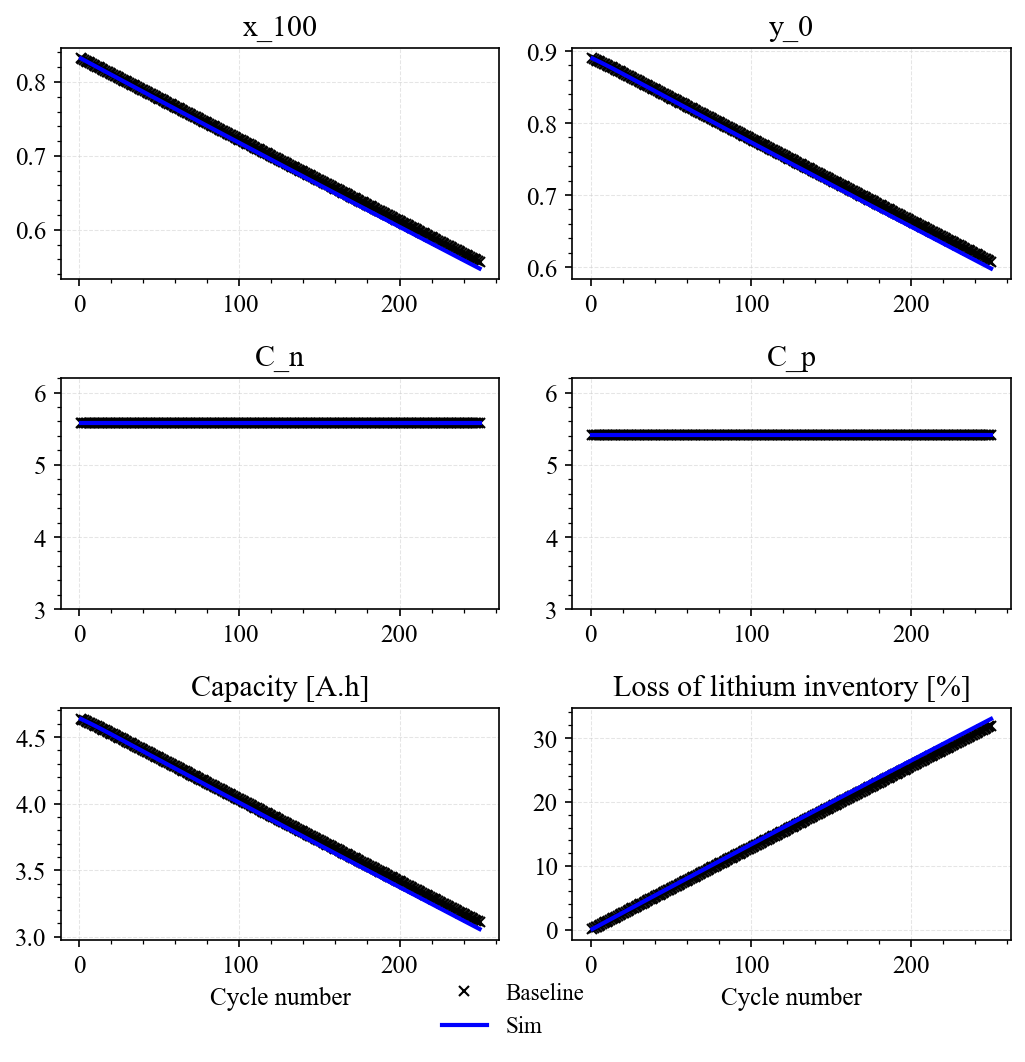

In [15]:
ii = 0
for kk in range(1):
    print('ksei='+str(kk))
    # sens_sim(ksei_idx=kk)
    # sens_sim(dsei_idx=kk)
    for dd in range(1):
        print('dsei='+str(dd))
        for tt in range(1,3):
            print('temp='+str(tt))
            sens_sim(ksei_idx=kk,dsei_idx=dd,Temp_idx=tt)
            ii+=1


In [ ]:
dasdas

NameError: name 'dasdas' is not defined

In [ ]:
calendar_time = 24
experiment = pybamm.Experiment(
    [
        ("Rest for "+f'{calendar_time}'+" hours",)
    ]*1,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [ ]:
ksei_idx = 0
dsei_idx = 0
Temp_idx = 0

In [ ]:
parameter_values = get_parameter_values()

parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
        "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
        "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
        # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
        "Initial temperature [K]": 273.15+Temp[Temp_idx],
        "Ambient temperature [K]": 273.15+Temp[Temp_idx],
    },
    check_already_exists=False,
)

In [ ]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_1 = sim_long.solve(initial_soc=1)
long_sol_output_1 =sol_1.summary_variables


In [ ]:
ksei_idx = 0
dsei_idx = 0
Temp_idx = 1

In [ ]:
parameter_values = get_parameter_values()

parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16*k_sei[ksei_idx], #1.6827e-16
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "Positive electrode LAM constant proportional term [s-1]": 5e-3/3600,
        "Negative electrode LAM constant proportional term [s-1]": 4.3e-2/3600,
        "EC diffusivity [m2.s-1]": 2e-18*d_sei[dsei_idx],
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial concentration in positive electrode [mol.m-3]": y_init*c_p_max,
        # "Initial concentration in negative electrode [mol.m-3]": x_init*c_n_max,
        "Initial temperature [K]": 273.15+Temp[Temp_idx],
        "Ambient temperature [K]": 273.15+Temp[Temp_idx],
    },
    check_already_exists=False,
)

In [ ]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_2 = sim_long.solve(initial_soc=1)
long_sol_output_2 =sol_2.summary_variables

In [ ]:
t_1 = sol_1["Time [s]"].entries
I_1 = sol_1["Current [A]"].entries
Q_1 = -sol_1['Discharge capacity [A.h]'].entries
Vt_1 = sol_1["Terminal voltage [V]"].entries

exp_1 = 30e6*sol_1["Cell thickness change [m]"].entries
exp_n_1 = 30e6*sol_1["Negative electrode thickness change [m]"].entries
exp_p_1 = 30e6*sol_1["Positive electrode thickness change [m]"].entries
ee_p_1 = sol_1["X-averaged positive electrode porosity"].entries
ee_n_1 = sol_1["X-averaged negative electrode porosity"].entries
ee_s_1 = sol_1["X-averaged separator porosity"].entries
j_n_1 = sol_1["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
j_p_1 = sol_1["X-averaged positive electrode total interfacial current density [A.m-2]"].entries
x = sol_1["x [m]"].entries
c_e_0 = sol_1["Electrolyte concentration [mol.m-3]"].entries

li_pl_v_1 = sol_1["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
li_pl_c_1 = sol_1["X-averaged lithium plating concentration [mol.m-3]"].entries
phi_n_1 = sol_1["X-averaged negative electrode potential [V]"].entries
phi_over_n_1 = sol_1["X-averaged negative electrode reaction overpotential [V]"].entries

In [ ]:
t_2 = sol_2["Time [s]"].entries
I_2 = sol_2["Current [A]"].entries
Q_2 = -sol_2['Discharge capacity [A.h]'].entries
Vt_2 = sol_2["Terminal voltage [V]"].entries

exp_2 = 30e6*sol_2["Cell thickness change [m]"].entries
# exp_n_2 = 30e6*sol_2["Negative Electrode thickness change [m]"].entries
# exp_p_2 = 30e6*sol_2["Positive Electrode thickness change [m]"].entries
ee_p_2 = sol_2["X-averaged positive electrode porosity"].entries
ee_n_2 = sol_2["X-averaged negative electrode porosity"].entries
ee_s_2 = sol_2["X-averaged separator porosity"].entries
j_n_2 = sol_2["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
j_p_2 = sol_2["X-averaged positive electrode total interfacial current density [A.m-2]"].entries
x = sol_2["x [m]"].entries
c_e_0 = sol_2["Electrolyte concentration [mol.m-3]"].entries

li_pl_v_2 = sol_2["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
li_pl_c_2 = sol_2["X-averaged lithium plating concentration [mol.m-3]"].entries
phi_n_2 = sol_2["X-averaged negative electrode potential [V]"].entries
phi_over_n_2 = sol_2["X-averaged negative electrode reaction overpotential [V]"].entries

In [ ]:
sei_cur_den_1 = sol_1["X-averaged outer SEI interfacial current density"].entries
sei_sur_pot_1 = sol_1["X-averaged negative electrode surface potential difference [V]"].entries
sei_ele_temp_1 = sol_1["X-averaged negative electrode temperature [K]"].entries

In [ ]:
sei_cur_den_2 = sol_2["X-averaged outer SEI interfacial current density"].entries
sei_sur_pot_2 = sol_2["X-averaged negative electrode surface potential difference [V]"].entries
sei_ele_temp_2 = sol_2["X-averaged negative electrode temperature [K]"].entries

In [ ]:
plt.figure()
plt.plot(t_1,sei_cur_den_1,t_2,sei_cur_den_2,'--')
plt.xlim(left=0)
plt.xlabel('Time [s]')
# plt.ylabel('Voltage [V]')
plt.title('X-averaged outer SEI interfacial current density')
plt.legend(['25 C, 45 C'])
plt.savefig(fig_DIR+'debug_temp_1'+'.png')

In [ ]:
plt.figure()
plt.plot(t_1,sei_sur_pot_1,t_2,sei_sur_pot_1,'--')
plt.xlim(left=0)
plt.xlabel('Time [s]')
# plt.ylabel('Voltage [V]')
plt.title('X-averaged negative electrode surface potential difference [V]')
plt.legend(['25 C, 45 C'])
plt.savefig(fig_DIR+'debug_temp_2'+'.png')

In [ ]:
plt.figure()
plt.plot(t_1,sei_ele_temp_1,t_2,sei_ele_temp_2,'--')
plt.xlim(left=0)
plt.xlabel('Time [s]')
# plt.ylabel('Voltage [V]')
plt.title('X-averaged negative electrode temperature [K]')
plt.legend(['25 C, 45 C'])
plt.savefig(fig_DIR+'debug_temp_3'+'.png')